In [224]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import seaborn as sns
import pandas as pd

In [226]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [227]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [228]:
from cdi.util.analysis.plotting import (plot_comparison, 
                                        barplot_comparison, 
                                        HandlerTupleVertical, 
                                        lighten_color,
                                        MulticolorPatch,
                                        MulticolorPatchHandler,
                                        TwocolorPatch,
                                        TwocolorPatchHandler)
from cdi.util.analysis.eval import (compute_avg_loglikelihood_w_std_err,
                                    compute_param_error,
                                    compute_avg_test_loglikelihood_vs_train_time,
                                    compute_avg_test_loglikelihood_vs_train_time_flows)
from cdi.util.stats_utils import load_statistics

## Analysis setup

### Global settings

In [229]:
data_name = 'flows_uci'
datasets = ['power', 'gas', 'hepmass', 'miniboone']
# exp_seed_key = 'm20190508_d20200325_20200406_20200407'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [230]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

eval_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/evaluations/tensors/{{}}'


## Helpers

In [231]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_val(group, model, seed, val_ckpt, filename):
    path = log_path_template_val.format(group, model, seed, val_ckpt, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_all_seeds(group, model, filename, exp_seed_keys=exp_seed_keys):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_val(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        for ckpt in val_ckpts[name]:
            name_i = f'{name} val{ckpt}'
            ckpt_name = f'{ckpt}_cust'
            try:
                stats[name_i] = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
    return stats

def read_suite_stats_val2(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        stats_i = defaultdict(list)
        for ckpt in val_ckpts[name]:
            try:
                ckpt_name = f'{ckpt}_cust'
                stat = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
                for k, v in stat.items():
                    # Append the last element from each key
                    stats_i[k].append(v[-1])
                stats_i['epoch'].append(ckpt)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
        stats[name] = stats_i
    return stats

def read_suite_stats_with_init_all_seeds(group, suite, exp_seed_keys=exp_seed_keys):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv', exp_seed_keys=exp_seed_keys)
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv', exp_seed_keys=exp_seed_keys)
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed, exp_seed_keys=exp_seed_keys):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv', exp_seed_keys=exp_seed_keys)
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv', exp_seed_keys=exp_seed_keys)
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


def ma(a, ws=10):
    return np.convolve(a[::-1], np.ones(ws)/ws, mode='valid')[::-1]

In [232]:
# ggplot
colors = ['#000000', '#E24A33', #'#988ED5', '#34b9bd', '#FBC15E', 
          '#348ABD', '#FFB5B8', '#777777', '#8EBA42',]

## Generative model analysis

### Log-likelihood analysis

For each method train a number of models using the same complete dataset but different missingness generated by changing only the random seed for the missingness generator. The fitted models are then used to compute fully-observed average log-likelihood on a held-out test dataset. Finally, the results from different seeds are averaged and standard error is computed.

In [75]:
suite_line = {
    'RQ-Flow (Complete)': 'rqcspline_{}_complete_data',
}

suite_subsampled = {
    'RQ-Flow (Subsampled)': 'rqcspline_{}_complete_data_subsampled'
}


suite_bar = {
    'VGI': 'rqcspline_{}_chrqsvar_cdi_uncondgauss',
#     'VGI2': 'rqcspline_{}_chrqsvar_cdi_uncondgauss_2',
    'PLMCMC': 'rqcspline_{}_plmcmc',
}
# groups = [1, 2, 3, 4, 5]
groups = [1, 3, 5]
# datasets = ['gas', 'hepmass', 'miniboone']

<IPython.core.display.Javascript object>


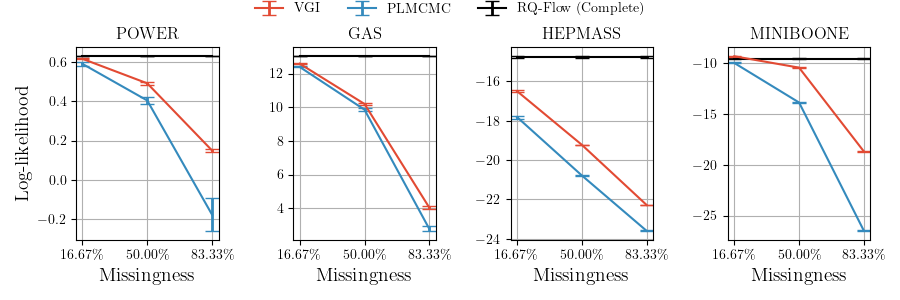

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(9, 3))
axes = axes.flatten()
# axes.set(title=f'Test log-likelihood')

for i, dataset in enumerate(datasets):
    suite_line_d = {
        name: file.format(dataset)
        for name, file in suite_line.items()
    }

    stats_line_d = {}
    # Load stats for every experiment in the suite
    for exp_name, model_name in suite_line_d.items():
        stats_line_d[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                                     seeds=exp_seed_keys,
                                                                     groups=groups,
                                                                     base_path=log_path_base)
    plot_comparison(axes[i], stats_line_d,
                    x_metric_key='group',
                    y_metric_keys=('test_log_lik',),  
                    err_keys=('test_log_lik_stderr',),
                    xlabel='Missingness',
                    ylabel='Log-likelihood', 
                    colors=colors,
    #                 ylim=(450, 1200))
                   legend=i==0)
    
    suite_bar_d = {
        name: file.format(dataset)
        for name, file in suite_bar.items()
    }
    
    stats_bar_d = {}
    # Load stats for every experiment in the suite
    for exp_name, model_name in suite_bar_d.items():
        stats_bar_d[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                                    seeds=exp_seed_keys,
                                                                    groups=groups,
                                                                    base_path=log_path_base,
                                                                    ignore_notfound=True,
                                                             filename_suffix='_last')

    # barplot_comparison(axes[i], stats_bar_d, width=0.09,
    #                     x_metric_key='group',
    #                     y_metric_keys=('test_log_lik',),  
    #                     err_keys=('test_log_lik_stderr',),
    #                     xlabel='Missingness',
    #                     ylabel='Log-likelihood', 
    #                     colors=colors[1:],
    # #                     edgecolors=[None, 'red'] + [None]*(len(colors)-3),
    # #                     ylim=(450, 1200),
    #                       gap=0.03, gap_idxs=[2]
    #                   )
    plot_comparison(axes[i], stats_bar_d, 
                    x_metric_key='group',
                    y_metric_keys=('test_log_lik',),  
                    err_keys=('test_log_lik_stderr',),
                    xlabel='Missingness',
                    ylabel='Log-likelihood', 
                    colors=colors[1:],
                    ylim=None,
                    legend=i==0)

    # for exp, model_name in suite_subsampled.items():
    #     stat_sub = compute_avg_loglikelihood_w_std_err(model_name, 
    #                                                    seeds=exp_seed_keys,
    #                                                    groups=groups,
    #                                                    base_path=log_path_base)

    #     for g in range(len(stat_sub['group'])):
    #         axes.hlines(stat_sub['test_log_lik'], 
    #                     xmin=np.array(stat_sub['group'])-0.5, 
    #                     xmax=np.array(stat_sub['group'])+0.5,
    #                     linestyles=[':'],
    #                     colors=colors[:1])

#     suite_sub_d = {
#         name: file.format(dataset)
#         for name, file in suite_subsampled.items()
#     }
    
#     stat_sub_d = {}
#     for exp, model_name in suite_sub_d.items():
#         stat_sub_d[exp] = compute_avg_loglikelihood_w_std_err(model_name, 
#                                                        seeds=exp_seed_keys,
#                                                        groups=groups,
#                                                        base_path=log_path_base)

#     plot_comparison(axes[i], stat_sub_d, 
#                     x_metric_key='group',
#                     y_metric_keys=('test_log_lik',),  
#                     err_keys=('test_log_lik_stderr',),
#                     xlabel='Missingness',
#                     ylabel='Log-likelihood', 
#                     colors=colors[:1],
#                     styles=[':'],
#                     ylim=None,
#                     legend=i==0)

    axes[i].set_xticks(groups)
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
    
    plt.setp(axes[i], title=dataset.upper())
    
#     if i in (0, 1):
#         plt.setp(axes[i].xaxis.label, visible=False)
    
    if i in (1, 2, 3):
        plt.setp(axes[i].yaxis.label, visible=False)

    axes[i].grid()

fig.tight_layout(rect=(0, 0, 1, 0.96))
# fig.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()

# handles = handles[1:-1] + [(mpl.lines.Line2D([0], [0], color=colors[0], linestyle='-'), 
#                           mpl.lines.Line2D([0], [0], color=colors[0], linestyle=':'))]
handles = handles[1:] + handles[:1]
labels = labels[1:] + labels[:1]

axes[0].legend(handles, labels,
            ncol=4, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
            frameon=False,
            handler_map = {tuple : HandlerTupleVertical()})


In [77]:
# fig.savefig('figures/rqcspline_alluci_test_loglik.pdf', bbox_inches='tight')

### Test-loglik vs train epoch and avg train iteration time

In [263]:
suite = {
    'VGI': 'rqcspline_{}_chrqsvar_cdi_uncondgauss',
    'PLMCMC': 'rqcspline_{}_plmcmc',
}

refit_ckpts = {
    'miniboone': {
        'VGI': [[10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850,
             900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 
             1700, -1]],
    'PLMCMC': [[10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850,
             900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 
             1700, -1]]
    },
    'gas': {
        'VGI': [[2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
            [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
            [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228,
               240, 252, 264, 276, 288, 300, 312, 324, 336, 348, 360, 372, 384, 396, 408, 420, 432, 444, 456, 468, 
               480, 492, 404, 416, 428, 440, 452, 464, 476, -1]],
        'PLMCMC': [[2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
                [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
                [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1]],
    },
    'power': {
        'VGI': [[2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 
                 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, -1]],
        'PLMCMC': [[2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 -1]],
    },
    'hepmass': {
        'VGI': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320,
                    340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, -1]],
        'PLMCMC': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, 340, 360,
                 380, 400, 420, 440, -1]],
    }
}

<IPython.core.display.Javascript object>


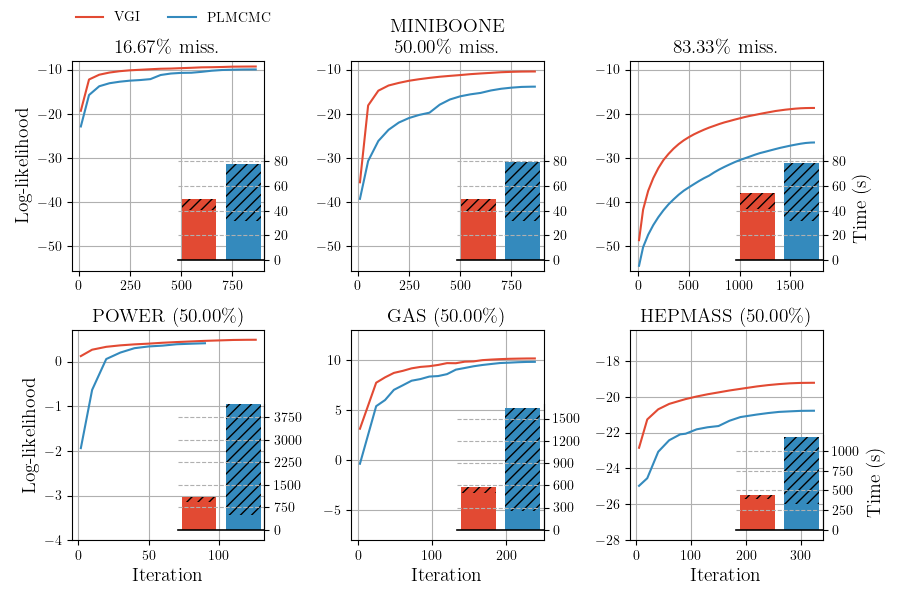

In [266]:
fig = plt.figure(constrained_layout=False, figsize=(9, 6))

top_exp = 'miniboone'
suite_d = {
        name: file.format(top_exp)
        for name, file in suite.items()
    }

axes_main = []
axes_sec = []
gs = [1, 3, 5]
time_stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    # Add another subplot in the *same* location for curves
    axes_main.append(fig.add_subplot(2,3,i+1, label='Loglik vs Time'))
    # A subplot for the time bars
    axes_sec.append(axes_main[i].inset_axes([0.55, 0.05, 0.45, 0.5], zorder=2))
    plt.setp(axes_sec[i].xaxis, label_position='bottom', ticks_position='bottom')
    axes_sec[i].get_xaxis().set_ticks([])
    plt.setp(axes_sec[i].yaxis, label_position='right', ticks_position='right')
    
    stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite_d)
    
    for m, s in stats_g.items():
        avg_train_time = np.array(s['train_time']).mean(axis=-1)
        avg_imp_time = np.array(s['train_imp_time']).mean(axis=-1)
        s['avg_train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
        s['avg_train_time'].append(avg_train_time.mean())
        s['avg_train_imp_time'].append(avg_imp_time.mean())
        s['dummy'] = [1]
        
    if i in (len(gs)-1, ):
        ylabel = 'Time (s)'
    else:
        ylabel=None
    
    barplot_comparison(axes_sec[i], stats_g, width=0.11,
                       gap=0.03, gap_idxs=[0],
                        x_metric_key='dummy',
                        y_metric_keys=('avg_train_imp_time',),  
                        err_keys=(None,),
                        y_bott_keys=('avg_train_time_minus_imp_time',),
                        xlabel=None,
                        ylabel=ylabel, 
                        colors=colors[1:],
                        hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                       legend=False
                      )
    
    barplot_comparison(axes_sec[i], stats_g, width=0.11,
                       gap=0.03, gap_idxs=[0],
                        x_metric_key='dummy',
                        y_metric_keys=('avg_train_time_minus_imp_time',),  
                        err_keys=(None,),
                        xlabel=None,
                        ylabel=ylabel, 
                        colors=colors[1:],
#                         hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                       legend=False
                      )
    
    stats = {}
    for exp_name, model_name in suite_d.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                       seeds=exp_seed_keys,
                                                                       ckpts=refit_ckpts[top_exp][exp_name][i],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes_main[i].set_title(label=f'{g/6*100:.2f}\% miss.', fontdict={'fontsize': 14})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

#     xlabel = 'Iteration'
    xlabel = None
        
    plot_comparison(axes_main[i], stats, 
                    x_metric_key='epoch',
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

    axes_sec[i].set_yticks([*range(0, 80+1, 20)])
    
    plt.setp(axes_main[i], 
             ylim=(-55.5, -8))
    plt.setp(axes_sec[i], 
             ylim=(0, 85))
#     axes_sec[i].set_xlabel("Method", fontsize=14)
    axes_sec[i].grid(linestyle='--')
    
    axes_sec[i].spines['left'].set_visible(False)
    axes_sec[i].spines['top'].set_visible(False)
    plt.setp(axes_sec[i].spines['bottom'], linewidth=1.2)
    
    axes_sec[i].patch.set_facecolor('#f0f0f0')
    axes_sec[i].patch.set_alpha(0.)

fig.text(0.5, 1.12, top_exp.upper(), color='k', visible=True, size=14,
         ha='center', va='bottom', transform=axes_main[1].transAxes)
    

## 2nd row left

left_exp = 'power'
suite_d = {
        name: file.format(left_exp)
        for name, file in suite.items()
    }
g = 3
i = 3
k = 1

# Add another subplot in the *same* location for curves
axes_main.append(fig.add_subplot(2,3,i+1, label='Loglik vs Time'))
# A subplot for the time bars
axes_sec.append(axes_main[i].inset_axes([0.55, 0.05, 0.45, 0.6], zorder=2))
plt.setp(axes_sec[i].xaxis, label_position='bottom', ticks_position='bottom')
axes_sec[i].get_xaxis().set_ticks([])
plt.setp(axes_sec[i].yaxis, label_position='right', ticks_position='right')

stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite_d)

for m, s in stats_g.items():
    maxx = 0
    # Ignore the couple of failed iterations towards the end for some seeds
    for t in s['train_time']:
        maxx = max(maxx, len(t))
    for j in range(len(s['train_time'])):
        s['train_time'][j] = np.pad(s['train_time'][j], (0, maxx-len(s['train_time'][j])), mode='constant', constant_values=np.nan)
    for j in range(len(s['train_imp_time'])):
        s['train_imp_time'][j] = np.pad(s['train_imp_time'][j], (0, maxx-len(s['train_imp_time'][j])), mode='constant', constant_values=np.nan)
    avg_train_time = np.nanmean(np.array(s['train_time']), axis=-1)
    avg_imp_time = np.nanmean(np.array(s['train_imp_time']), axis=-1)
#         s['avg_train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
    s['avg_train_time_minus_imp_time'].append(np.nanmean((np.array(s['train_time']) 
                                                - np.array(s['train_imp_time'])).mean(axis=-1)))
    s['avg_train_time'].append(avg_train_time.mean())
    s['avg_train_imp_time'].append(avg_imp_time.mean())
    s['dummy'] = [1]

barplot_comparison(axes_sec[i], stats_g, width=0.11,
                   gap=0.03, gap_idxs=[0],
                    x_metric_key='dummy',
                    y_metric_keys=('avg_train_imp_time',),  
                    err_keys=(None,),
                    y_bott_keys=('avg_train_time_minus_imp_time',),
                    xlabel=None,
                    ylabel=ylabel, 
                    colors=colors[1:],
                    hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )

barplot_comparison(axes_sec[i], stats_g, width=0.11,
                   gap=0.03, gap_idxs=[0],
                    x_metric_key='dummy',
                    y_metric_keys=('avg_train_time_minus_imp_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel=ylabel, 
                    colors=colors[1:],
#                         hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )

stats = {}
for exp_name, model_name in suite_d.items():
    stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                   seeds=exp_seed_keys,
                                                                   ckpts=refit_ckpts[left_exp][exp_name][k],
                                                                   group=g,
                                                                   base_path=log_path_base,
                                                                   ignore_notfound=True,)

axes_main[i].set_title(label=f'{left_exp.upper()} ({g/6*100:.2f}\%)', fontdict={'fontsize': 14})
ylabel = 'Log-likelihood'

xlabel = 'Iteration'

plot_comparison(axes_main[i], stats, 
                x_metric_key='epoch',
                y_metric_keys=('test_log_lik', ),
                err_keys=(None, ),
                xlabel=xlabel,
                ylabel=ylabel, 
#                     ylim=ylims[i],
                legend=False,
                colors=colors[1:4]+ colors[5:],
                ignore_nan=True)

axes_sec[i].set_yticks([*range(0, 4200+1, 750)])

plt.setp(axes_main[i], 
         ylim=(-4, 0.7))
plt.setp(axes_sec[i], 
         ylim=(0, 4200))
# axes_sec[i].set_xlabel("Method", fontsize=14)
axes_sec[i].grid(linestyle='--')

axes_sec[i].spines['left'].set_visible(False)
axes_sec[i].spines['top'].set_visible(False)
plt.setp(axes_sec[i].spines['bottom'], linewidth=1.2)

axes_sec[i].patch.set_facecolor('#f0f0f0')
axes_sec[i].patch.set_alpha(0.)




## 2nd row centre
ylabel = None

centre_exp = 'gas'
suite_d = {
        name: file.format(centre_exp)
        for name, file in suite.items()
    }
g = 3
i = 4
k = 1

# Add another subplot in the *same* location for curves
axes_main.append(fig.add_subplot(2,3,i+1, label='Loglik vs Time'))
# A subplot for the time bars
axes_sec.append(axes_main[i].inset_axes([0.55, 0.05, 0.45, 0.6], zorder=2))
plt.setp(axes_sec[i].xaxis, label_position='bottom', ticks_position='bottom')
axes_sec[i].get_xaxis().set_ticks([])
plt.setp(axes_sec[i].yaxis, label_position='right', ticks_position='right')

stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite_d)

for m, s in stats_g.items():
    maxx = 0
    # Ignore the couple of failed iterations towards the end for some seeds
    for t in s['train_time']:
        maxx = max(maxx, len(t))
    for j in range(len(s['train_time'])):
        s['train_time'][j] = np.pad(s['train_time'][j], (0, maxx-len(s['train_time'][j])), mode='constant', constant_values=np.nan)
    for j in range(len(s['train_imp_time'])):
        s['train_imp_time'][j] = np.pad(s['train_imp_time'][j], (0, maxx-len(s['train_imp_time'][j])), mode='constant', constant_values=np.nan)
    avg_train_time = np.nanmean(np.array(s['train_time']), axis=-1)
    avg_imp_time = np.nanmean(np.array(s['train_imp_time']), axis=-1)
#         s['avg_train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
    s['avg_train_time_minus_imp_time'].append(np.nanmean((np.array(s['train_time']) 
                                                - np.array(s['train_imp_time'])).mean(axis=-1)))
    s['avg_train_time'].append(avg_train_time.mean())
    s['avg_train_imp_time'].append(avg_imp_time.mean())
    s['dummy'] = [1]

barplot_comparison(axes_sec[i], stats_g, width=0.11,
                   gap=0.03, gap_idxs=[0],
                    x_metric_key='dummy',
                    y_metric_keys=('avg_train_imp_time',),  
                    err_keys=(None,),
                    y_bott_keys=('avg_train_time_minus_imp_time',),
                    xlabel=None,
                    ylabel=ylabel, 
                    colors=colors[1:],
                    hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )

barplot_comparison(axes_sec[i], stats_g, width=0.11,
                   gap=0.03, gap_idxs=[0],
                    x_metric_key='dummy',
                    y_metric_keys=('avg_train_time_minus_imp_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel=ylabel, 
                    colors=colors[1:],
#                         hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )

stats = {}
for exp_name, model_name in suite_d.items():
    stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                   seeds=exp_seed_keys,
                                                                   ckpts=refit_ckpts[centre_exp][exp_name][k],
                                                                   group=g,
                                                                   base_path=log_path_base)

axes_main[i].set_title(label=f'{centre_exp.upper()} ({g/6*100:.2f}\%)', fontdict={'fontsize': 14})

xlabel = 'Iteration'

plot_comparison(axes_main[i], stats, 
                x_metric_key='epoch',
                y_metric_keys=('test_log_lik', ),
                err_keys=(None, ),
                xlabel=xlabel,
                ylabel=ylabel, 
#                     ylim=ylims[i],
                legend=False,
                colors=colors[1:4]+ colors[5:])

axes_sec[i].set_yticks([*range(0, 1800+1, 300)])

plt.setp(axes_main[i], 
         ylim=(-8, 13))
plt.setp(axes_sec[i], 
         ylim=(0, 1700))
# axes_sec[i].set_xlabel("Method", fontsize=14)
axes_sec[i].grid(linestyle='--')

axes_sec[i].spines['left'].set_visible(False)
axes_sec[i].spines['top'].set_visible(False)
plt.setp(axes_sec[i].spines['bottom'], linewidth=1.2)

axes_sec[i].patch.set_facecolor('#f0f0f0')
axes_sec[i].patch.set_alpha(0.)



## 2nd row right


right_exp = 'hepmass'
suite_d = {
        name: file.format(right_exp)
        for name, file in suite.items()
    }
g = 3
i = 5
k = 1

ylabel = 'Time (s)'

# Add another subplot in the *same* location for curves
axes_main.append(fig.add_subplot(2,3,i+1, label='Loglik vs Time'))
# A subplot for the time bars
axes_sec.append(axes_main[i].inset_axes([0.55, 0.05, 0.45, 0.45], zorder=2))
plt.setp(axes_sec[i].xaxis, label_position='bottom', ticks_position='bottom')
axes_sec[i].get_xaxis().set_ticks([])
plt.setp(axes_sec[i].yaxis, label_position='right', ticks_position='right')

stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite_d)

for m, s in stats_g.items():
    avg_train_time = np.array(s['train_time']).mean(axis=-1)
    avg_imp_time = np.array(s['train_imp_time']).mean(axis=-1)
    s['avg_train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
    s['avg_train_time'].append(avg_train_time.mean())
    s['avg_train_imp_time'].append(avg_imp_time.mean())
    s['dummy'] = [1]

barplot_comparison(axes_sec[i], stats_g, width=0.11,
                   gap=0.03, gap_idxs=[0],
                    x_metric_key='dummy',
                    y_metric_keys=('avg_train_imp_time',),  
                    err_keys=(None,),
                    y_bott_keys=('avg_train_time_minus_imp_time',),
                    xlabel=None,
                    ylabel=ylabel, 
                    colors=colors[1:],
                    hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )

barplot_comparison(axes_sec[i], stats_g, width=0.11,
                   gap=0.03, gap_idxs=[0],
                    x_metric_key='dummy',
                    y_metric_keys=('avg_train_time_minus_imp_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel=ylabel, 
                    colors=colors[1:],
#                         hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )

stats = {}
for exp_name, model_name in suite_d.items():
    stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                   seeds=exp_seed_keys,
                                                                   ckpts=refit_ckpts[right_exp][exp_name][k],
                                                                   group=g,
                                                                   base_path=log_path_base)

axes_main[i].set_title(label=f'{right_exp.upper()} ({g/6*100:.2f}\%)', fontdict={'fontsize': 14})
if i in (0, ):
    ylabel = 'Log-likelihood'
else:
    ylabel=None

xlabel = 'Iteration'

plot_comparison(axes_main[i], stats, 
                x_metric_key='epoch',
                y_metric_keys=('test_log_lik', ),
                err_keys=(None, ),
                xlabel=xlabel,
                ylabel=ylabel, 
#                     ylim=ylims[i],
                legend=False,
                colors=colors[1:4]+ colors[5:])

axes_sec[i].set_yticks([*range(0, 1200+1, 250)])

plt.setp(axes_main[i], 
         ylim=(-28, -16.3))
plt.setp(axes_sec[i], 
         ylim=(0, 1200))
# axes_sec[i].set_xlabel("Method", fontsize=14)
axes_sec[i].grid(linestyle='--')

axes_sec[i].spines['left'].set_visible(False)
axes_sec[i].spines['top'].set_visible(False)
plt.setp(axes_sec[i].spines['bottom'], linewidth=1.2)

axes_sec[i].patch.set_facecolor('#f0f0f0')
axes_sec[i].patch.set_alpha(0.)

fig.tight_layout(rect=(0, 0, 1, 0.96))

handles, labels = axes_main[0].get_legend_handles_labels()
axes_main[0].legend(handles, labels,
            ncol=4, bbox_to_anchor=(0.07, 0.97), bbox_transform=fig.transFigure, loc='center left', 
            frameon=False,
            handler_map = {tuple : HandlerTupleVertical()})


In [267]:
# fig.savefig('figures/rqcspline_alluci_test_loglik_vs_iter_and_avg_time.pdf', bbox_inches='tight')

### Rest of test-loglik vs train epoch and avg train iteration time

In [234]:
suite = {
    'VGI': 'rqcspline_{}_chrqsvar_cdi_uncondgauss',
    'PLMCMC': 'rqcspline_{}_plmcmc',
}

refit_ckpts = {
    'miniboone': {
        'VGI': [[10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850,
             900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 
             1700, -1]],
    'PLMCMC': [[10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, -1],
            [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850,
             900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 
             1700, -1]]
    },
    'gas': {
        'VGI': [[2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
            [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
            [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228,
               240, 252, 264, 276, 288, 300, 312, 324, 336, 348, 360, 372, 384, 396, 408, 420, 432, 444, 456, 468, 
               480, 492, 404, 416, 428, 440, 452, 464, 476, -1]],
        'PLMCMC': [[2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
                [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1],
                [2, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, -1]],
    },
    'power': {
        'VGI': [[2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 
                 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, -1]],
        'PLMCMC': [[2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 -1],
                [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 -1]],
    },
    'hepmass': {
        'VGI': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320,
                    340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, -1]],
        'PLMCMC': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
                [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, 340, 360,
                 380, 400, 420, 440, -1]],
    }
}

<IPython.core.display.Javascript object>


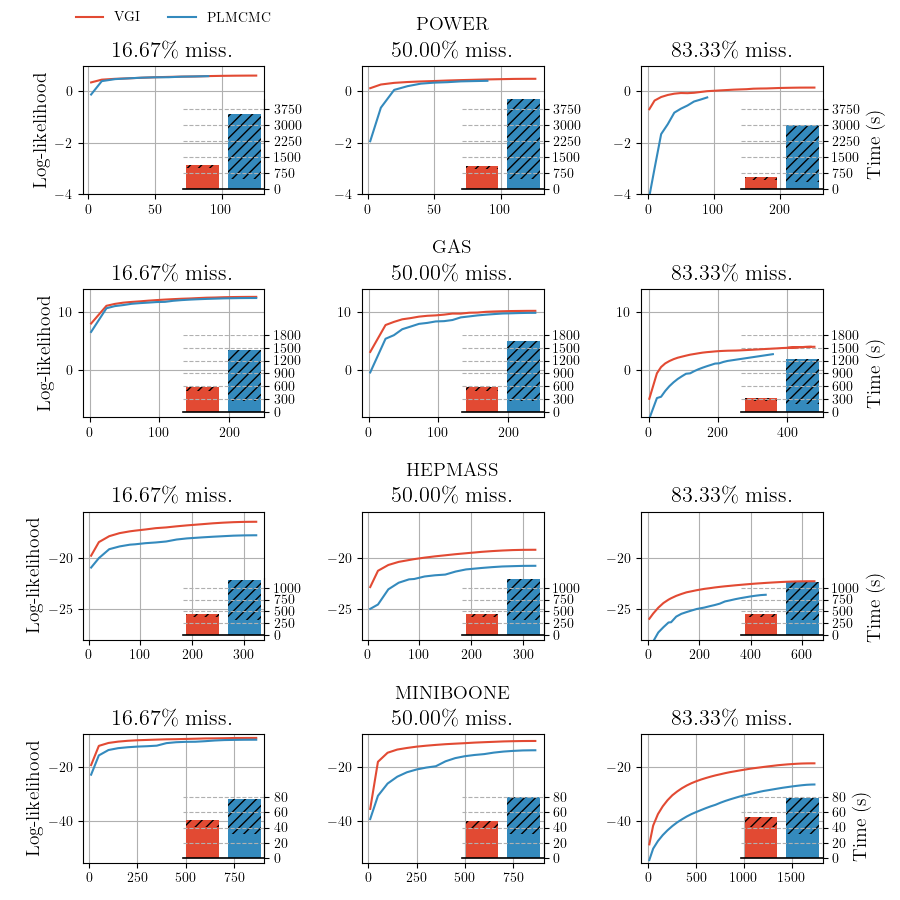

In [261]:
fig = plt.figure(constrained_layout=False, figsize=(9, 9))

# datasets = ['gas', 'hepmass', 'miniboone']
axes_main = []
axes_sec = []
gs = [1, 3, 5]

main_ylim = ((-4, 1.0),
             (-8, 14),
             (-28, -15.5),
             (-55.5, -8))
sec_ylim = ((0, 4200),
            (0, 1700),
            (0, 1200),
            (0, 85))
sec_ymax = (4200, 1800, 1200, 80)
sec_yinc = (750, 300, 250, 20)
sec_height = (0.7, 0.6, 0.44, 0.5)

for l, dataset in enumerate(datasets):
    suite_line_d = {
        name: file.format(dataset)
        for name, file in suite.items()
    }
    
    time_stats = defaultdict(lambda: defaultdict(list))
    for i, g in enumerate(gs, start=l*3):
        # Add another subplot in the *same* location for curves
        axes_main.append(fig.add_subplot(4,3,i+1, label='Loglik vs Time'))
        # A subplot for the time bars
        axes_sec.append(axes_main[i].inset_axes([0.55, 0.04, 0.45, sec_height[l]], zorder=2))
        
        plt.setp(axes_sec[i].xaxis, label_position='bottom', ticks_position='bottom')
        axes_sec[i].get_xaxis().set_ticks([])
        plt.setp(axes_sec[i].yaxis, label_position='right', ticks_position='right')

        stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite_line_d)

        for m, s in stats_g.items():
            maxx = 0
            # Ignore the couple of failed iterations towards the end for some seeds
            for t in s['train_time']:
                maxx = max(maxx, len(t))
            for j in range(len(s['train_time'])):
                s['train_time'][j] = np.pad(s['train_time'][j], (0, maxx-len(s['train_time'][j])), mode='constant', constant_values=np.nan)
            for j in range(len(s['train_imp_time'])):
                s['train_imp_time'][j] = np.pad(s['train_imp_time'][j], (0, maxx-len(s['train_imp_time'][j])), mode='constant', constant_values=np.nan)
            avg_train_time = np.nanmean(np.array(s['train_time']), axis=-1)
            avg_imp_time = np.nanmean(np.array(s['train_imp_time']), axis=-1)
    #         s['avg_train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
            s['avg_train_time_minus_imp_time'].append(np.nanmean((np.array(s['train_time']) 
                                                        - np.array(s['train_imp_time'])).mean(axis=-1)))
            s['avg_train_time'].append(avg_train_time.mean())
            s['avg_train_imp_time'].append(avg_imp_time.mean())
            s['dummy'] = [1]

        if i in (2, 5, 8, 11):
            ylabel = 'Time (s)'
        else:
            ylabel=None

        barplot_comparison(axes_sec[i], stats_g, width=0.11,
                           gap=0.03, gap_idxs=[0],
                            x_metric_key='dummy',
                            y_metric_keys=('avg_train_imp_time',),  
                            err_keys=(None,),
                            y_bott_keys=('avg_train_time_minus_imp_time',),
                            xlabel=None,
                            ylabel=ylabel, 
                            colors=colors[1:],
                            hatches=['///']*3 + [None]*4,
    #                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                           legend=False
                          )

        barplot_comparison(axes_sec[i], stats_g, width=0.11,
                           gap=0.03, gap_idxs=[0],
                            x_metric_key='dummy',
                            y_metric_keys=('avg_train_time_minus_imp_time',),  
                            err_keys=(None,),
                            xlabel=None,
                            ylabel=ylabel, 
                            colors=colors[1:],
    #                         hatches=['///']*3 + [None]*4,
    #                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                           legend=False
                          )



        stats = {}
        for exp_name, model_name in suite_line_d.items():
            stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                           seeds=exp_seed_keys,
                                                                           ckpts=refit_ckpts[dataset][exp_name][i-l*3],
                                                                           group=g,
                                                                           base_path=log_path_base,
                                                                           ignore_notfound=True)

        axes_main[i].set_title(label=f'{g/6*100:.2f}\% miss.', fontdict={'fontsize': 16})
        if i in (0, 3, 6, 9):
            ylabel = 'Log-likelihood'
        else:
            ylabel=None

        if l == 4:
            xlabel = 'Iteration'
        else: 
            xlabel = None

        plot_comparison(axes_main[i], stats, 
                        x_metric_key='epoch',
                        y_metric_keys=('test_log_lik', ),
                        err_keys=(None, ),
                        xlabel=xlabel,
                        ylabel=ylabel, 
    #                     ylim=ylims[i],
                        legend=False,
                        colors=colors[1:4]+ colors[5:],
                       ignore_nan=True)

        plt.setp(axes_main[i], 
                 ylim=main_ylim[l])
        plt.setp(axes_sec[i], 
                 ylim=sec_ylim[l])
    #     axes_sec[i].set_xlabel("Method", fontsize=14)
        axes_sec[i].grid(linestyle='--')
        axes_sec[i].set_yticks([*range(0, sec_ymax[l]+1, sec_yinc[l])])

        axes_sec[i].spines['left'].set_visible(False)
        axes_sec[i].spines['top'].set_visible(False)
        plt.setp(axes_sec[i].spines['bottom'], linewidth=1.2)

        axes_sec[i].patch.set_facecolor('#f0f0f0')
        axes_sec[i].patch.set_alpha(0.)
    
# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.97), h_pad=3.5)

fig.text(0.5, 1.25, datasets[0].upper(), color='k', visible=True, size=14, 
         ha='center', va='bottom', transform=axes_main[1].transAxes)
fig.text(0.5, 1.25, datasets[1].upper(), color='k', visible=True, size=14, 
         ha='center', va='bottom', transform=axes_main[4].transAxes)
fig.text(0.5, 1.25, datasets[2].upper(), color='k', visible=True, size=14, 
         ha='center', va='bottom', transform=axes_main[7].transAxes)
fig.text(0.5, 1.25, datasets[3].upper(), color='k', visible=True, size=14, 
         ha='center', va='bottom', transform=axes_main[10].transAxes)

handles, labels = axes_main[0].get_legend_handles_labels()
axes_main[0].legend(handles, labels,
            ncol=4, bbox_to_anchor=(0.07, 0.98), bbox_transform=fig.transFigure, loc='center left', 
            frameon=False,
            handler_map = {tuple : HandlerTupleVertical()})



In [262]:
# fig.savefig('figures/rqcspline_alluci_test_loglik_vs_iter_and_avg_time_rest.pdf', bbox_inches='tight')

### Long-run

In [155]:
colors_dark = [lighten_color(c, 1.5) for c in colors]

<IPython.core.display.Javascript object>


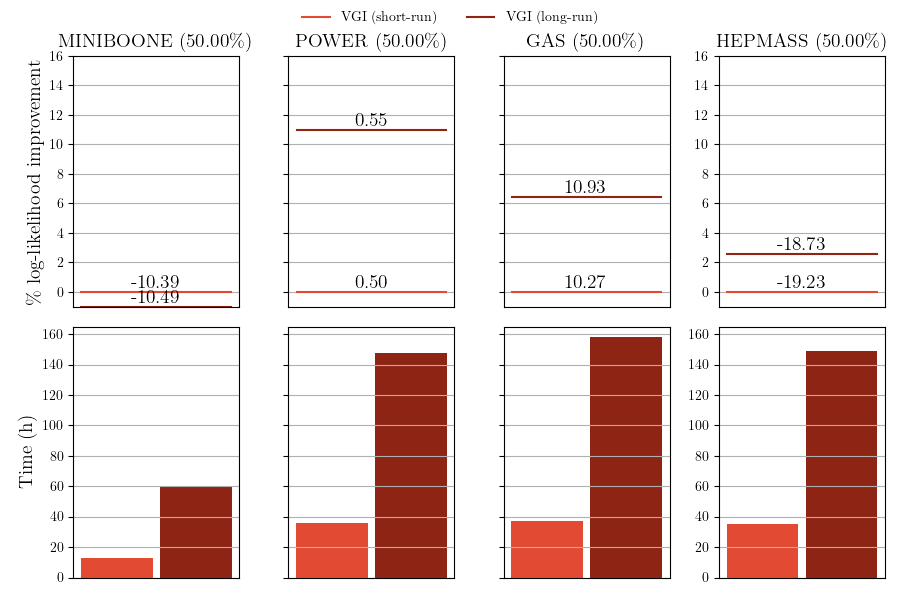

In [271]:
suite_complete = {
    'RQ-Flow (Complete)': 'rqcspline_{}_complete_data',
#     'PLMCMC': 'rqcspline_{}_plmcmc',
}
suite = {
    'VGI': 'rqcspline_{}_chrqsvar_cdi_uncondgauss',
#     'PLMCMC': 'rqcspline_{}_plmcmc',
}
suite_longrun = {
    'VGI': 'rqcspline_{}_chrqsvar_cdi_uncondgauss_longrun',
#     'PLMCMC': 'rqcspline_{}_plmcmc',
}
dd = ['miniboone', 'power', 'gas', 'hepmass']

g = 3

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))
axes = axes.flatten()

for l, dataset in enumerate(dd):
    suite_line_d = {
        name: file.format(dataset)
        for name, file in suite.items()
    }
#     for i, g in enumerate(gs):
    train_stats = read_all_suite_stats([g], suite_line_d, 'summary.csv', exp_seed_keys[0])[g]
    stats = {}
    for exp_name, model_name in suite_line_d.items():
        stats[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                              seeds=[exp_seed_keys[0]],
                                                              groups=[g],
                                                              base_path=log_path_base,
                                                              ignore_notfound=False,
                                                              filename_suffix='_last')
        stats[exp_name]['data'] = [l]
        stats[exp_name] = {**(stats[exp_name]), **(train_stats[exp_name])}
    
    suite_line_d = {
        name: file.format(dataset)
        for name, file in suite_complete.items()
    }
#     for i, g in enumerate(gs):
    train_stats = read_all_suite_stats([g], suite_line_d, 'summary.csv', exp_seed_keys[0])[g]
    stats_complete = {}
    for exp_name, model_name in suite_line_d.items():
        stats_complete[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                              seeds=[exp_seed_keys[0]],
                                                              groups=[g],
                                                              base_path=log_path_base,
                                                              ignore_notfound=False,
                                                              filename_suffix='')
        stats_complete[exp_name]['data'] = [l]
        stats_complete[exp_name] = {**(stats_complete[exp_name]), **(train_stats[exp_name])}

        
    suite_line_d = {
        name: file.format(dataset)
        for name, file in suite_longrun.items()
    }
#     for i, g in enumerate(gs):
    train_stats = read_all_suite_stats([g], suite_line_d, 'summary.csv', exp_seed_keys[0])[g]
    stats_long = {}
    for exp_name, model_name in suite_line_d.items():
        stats_long[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                              seeds=[exp_seed_keys[0]],
                                                              groups=[g],
                                                              base_path=log_path_base,
                                                              ignore_notfound=False,
                                                              filename_suffix='')
        stats_long[exp_name]['data'] = [l]
        stats_long[exp_name] = {**(stats_long[exp_name]), **(train_stats[exp_name])}

    
    percent = 100*(np.array(stats_long['VGI']['test_log_lik'])-np.array(stats['VGI']['test_log_lik']))/np.abs(np.array(stats['VGI']['test_log_lik']))
    axes[l].axhline(0, 0.05, 0.95, color=colors[1], label='VGI (short-run)')
    axes[l].text(0.5, 0., f'{(stats["VGI"]["test_log_lik"][0]):.2f}', fontsize=14, 
                 va='bottom', ha='center')
    axes[l].axhline(percent, 0.05, 0.95, color=colors_dark[1], label='VGI (long-run)')
    axes[l].text(0.5, percent, f'{(stats_long["VGI"]["test_log_lik"][0]):.2f}', fontsize=14, 
                 va='bottom', ha='center')
#     percent_complete = 100*(np.array(stats_complete['RQ-Flow (Complete)']['test_log_lik'])-np.array(stats['VGI']['test_log_lik']))/np.abs(np.array(stats['VGI']['test_log_lik']))
#     axes[l].axhline(percent_complete, 0.05, 0.95, color=colors[0], label='RQ-Flow (Complete)',
#                     linestyle='--')
#     axes[l].text(0.5, percent_complete, f'{(stats_complete["RQ-Flow (Complete)"]["test_log_lik"][0]):.2f}', fontsize=14, 
#                  va='bottom', ha='center')
    
    axes[l].get_xaxis().set_ticks([])
    axes[l].grid()
    plt.setp(axes[l], ylim=(-1, 16))
    if l == 0:
        axes[l].set_ylabel('\% log-likelihood improvement', fontsize=14)
    if l in (1, 2):
        axes[l].get_yaxis().set_ticklabels([])
    axes[l].set_title(label=f'{dataset.upper()} ({g/6*100:.2f}\%)', fontdict={'fontsize': 14})
    
    
#     inax = axes[l].inset_axes([0.5, 0., 0.5, 1.], zorder=2)
#     plt.setp(inax.yaxis, label_position='right', ticks_position='right')
    axes[l+len(dd)].get_xaxis().set_ticks([])
    axes[l+len(dd)].grid()
    plt.setp(axes[l+len(dd)], ylim=(0, 165))
    if l in (1, 2):
        axes[l+len(dd)].get_yaxis().set_ticklabels([])
    if l == 0:
        axes[l+len(dd)].set_ylabel('Time (h)', fontsize=14)
    
    axes[l+len(dd)].bar(0, np.array(stats['VGI']['train_time']).sum()/60/60, 
             color=colors[1],
             width=1)

    if dataset == 'miniboone':
        axes[l+len(dd)].bar(1.1, np.array(stats_long['VGI']['train_time'][:4664]).sum()/60/60, 
                 color=colors_dark[1],
                 width=1)
    else:
        axes[l+len(dd)].bar(1.1, np.array(stats_long['VGI']['train_time']).sum()/60/60, 
                 color=colors_dark[1],
                 width=1)
    
fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels,
            ncol=3, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
            frameon=False,
            handler_map = {tuple : HandlerTupleVertical()})

In [223]:
# fig.savefig('figures/rqcspline_uci_longrun.pdf', bbox_inches='tight')

### Fully autoregressive

In [15]:
coup_suite = {
    'RQ-Flow (Complete)': 'rqcspline_miniboone_complete_data',
    'VGI': 'rqcspline_miniboone_chrqsvar_cdi_uncondgauss',
    'PLMCMC': 'rqcspline_miniboone_plmcmc',
}

ar_suite = {
    'RQ-Flow (Complete)': 'rqarspline_miniboone_complete_data',
    'VGI': 'rqarspline_miniboone_chrqsvar_cdi_uncondgauss',
    'PLMCMC': 'rqarspline_miniboone_plmcmc',
}



In [47]:
colors_light = [lighten_color(c, 0.7) for c in colors]

<IPython.core.display.Javascript object>


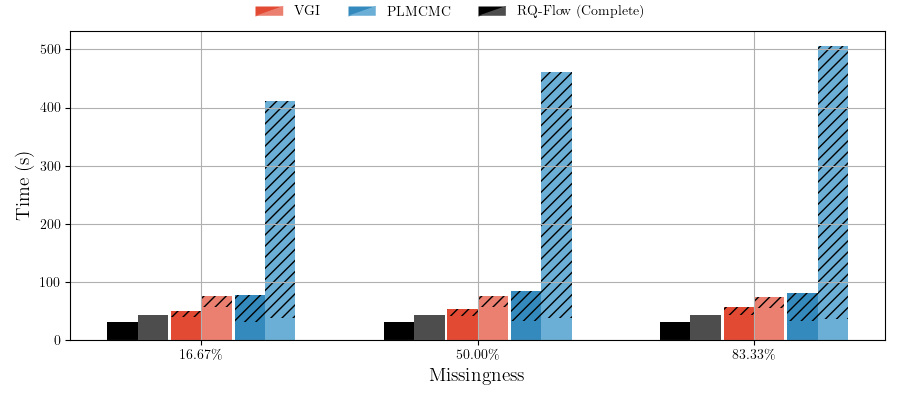

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
gs = [1, 3, 5]

stats_coup = defaultdict(lambda: defaultdict(list))
stats_ar = defaultdict(lambda: defaultdict(list))
for g in gs:
    stats = read_suite_stats_with_init_all_seeds(group=g, suite=coup_suite, exp_seed_keys=[exp_seed_keys[0]])
    for m, s in stats.items():
        avg_train_time = np.array(s['train_time']).mean(axis=-1)
        if len(s['train_imp_time']) != 0:
            avg_imp_time = np.array(s['train_imp_time']).mean(axis=-1)
        else:
            avg_imp_time = np.array([0.])
        stats_coup[m]['train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
        stats_coup[m]['train_time'].append(avg_train_time.mean())
        stats_coup[m]['train_imp_time'].append(avg_imp_time.mean())
        stats_coup[m]['group'].append(g)

    stats = read_suite_stats_with_init_all_seeds(group=g, suite=ar_suite, exp_seed_keys=[exp_seed_keys[0]])
    for m, s in stats.items():
        avg_train_time = np.array(s['train_time']).mean(axis=-1)
        if len(s['train_imp_time']) != 0:
            avg_imp_time = np.array(s['train_imp_time']).mean(axis=-1)
        else:
            avg_imp_time = np.array([0.])
        stats_ar[m]['train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
        stats_ar[m]['train_time'].append(avg_train_time.mean())
        stats_ar[m]['train_imp_time'].append(avg_imp_time.mean())
        stats_ar[m]['group'].append(g)

barplot_comparison(axes, stats_coup, width=0.11,
                   gap=0.12, gap_idxs=[0,1,2],
                   x_offset=0.005,
                    x_metric_key='group',
                    y_metric_keys=('train_imp_time',),  
                    err_keys=(None,),
                    y_bott_keys=('train_time_minus_imp_time',),
                    xlabel='Missingness',
                    ylabel='Time (s)', 
                    colors=colors,
                    hatches=['///']*3,
                    alpha=0.999  # Workaround for hatches disappearing when rendering to pdf
                  )
    
barplot_comparison(axes, stats_coup, width=0.11,
                   gap=0.12, gap_idxs=[0,1,2],
                   x_offset=0.005,
                    x_metric_key='group',
                    y_metric_keys=('train_time_minus_imp_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel=None, 
                    colors=colors,
                  )

barplot_comparison(axes, stats_ar, width=0.11,
                   gap=0.12, gap_idxs=[0,1,2],
                   x_offset=0.115,
                    x_metric_key='group',
                    y_metric_keys=('train_imp_time',),  
                    err_keys=(None,),
                    y_bott_keys=('train_time_minus_imp_time',),
                    xlabel='Missingness',
                    ylabel='Time (s)', 
                    colors=colors_light,
                    hatches=['///']*3,
                    alpha=0.999  # Workaround for hatches disappearing when rendering to pdf
                  )
    
barplot_comparison(axes, stats_ar, width=0.11,
                   gap=0.12, gap_idxs=[0,1,2],
                   x_offset=0.115,
                    x_metric_key='group',
                    y_metric_keys=('train_time_minus_imp_time',),  
                    err_keys=(None,),
                    xlabel='Missingness',
                    ylabel='Time (s)', 
                    colors=colors_light,
                  )

axes.grid()

axes.set_xticks(list(range(1, len(gs)+1)))
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in gs))

fig.tight_layout(rect=(0, 0, 1, 0.96))

handles, labels = axes.get_legend_handles_labels()

handles = [TwocolorPatch([colors[1], colors_light[1]]),
           TwocolorPatch([colors[2], colors_light[2]]),
           TwocolorPatch([colors[0], colors_light[0]])]
labels = labels[1:3] + labels[:1]

axes.legend(handles, labels,
            ncol=3, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
            handler_map={MulticolorPatch: MulticolorPatchHandler(), TwocolorPatch: TwocolorPatchHandler()}, 
            frameon=False, )

In [94]:
# fig.savefig('figures/rqcspline_miniboone_ar_avg_time.pdf', bbox_inches='tight')